## Use Rapids Env, Generate UMAP embeddings. 

In [38]:
import pathlib
import numpy as np
import cupy as cp
from cuml.manifold import UMAP as UMAP_cuml
from cuml.cluster import HDBSCAN as HDBSCAN_cuml
from scipy.stats import mode
from tqdm.auto import tqdm
import gc

# --- Helper Functions ---

def majority_vote(data, window_size=1):
    """
    Return an array of the same length as 'data',
    where each index i is replaced by the majority over
    a window around i. No padding is added.
    """
    import numpy as np
    from collections import Counter

    data = np.asarray(data)
    n = len(data)
    
    # If window_size=1, no smoothing
    if window_size <= 1 or n == 0:
        return data.copy()
    
    half_w = window_size // 2
    output = np.zeros_like(data)
    
    for i in range(n):
        # define start/end, clamped
        start = max(0, i - half_w)
        end   = min(n, i + half_w + 1)
        window = data[start:end]
        
        # majority
        c = Counter(window)
        major_label = max(c, key=c.get)  # picks the label with highest freq
        output[i] = major_label
    
    return output

def fill_noise_with_nearest_label(labels):
    noise_indices = np.where(labels == -1)[0]
    non_noise_indices = np.where(labels != -1)[0]
    if len(noise_indices) == 0 or len(non_noise_indices) == 0: return labels
    right_neighbor_idxs = np.searchsorted(non_noise_indices, noise_indices)
    left_neighbor_idxs = right_neighbor_idxs - 1
    right_neighbor_idxs[right_neighbor_idxs == len(non_noise_indices)] = len(non_noise_indices) - 1
    dist_right = np.abs(non_noise_indices[right_neighbor_idxs] - noise_indices).astype(float)
    dist_left = np.abs(noise_indices - non_noise_indices[left_neighbor_idxs]).astype(float)
    dist_left[left_neighbor_idxs < 0] = np.inf
    winner_indices = np.where(dist_right <= dist_left, non_noise_indices[right_neighbor_idxs], non_noise_indices[left_neighbor_idxs])
    labels[noise_indices] = labels[winner_indices]
    return labels

# --- Constants ---
ROOT = pathlib.Path().resolve()
NPZ_DIR = pathlib.Path("/media/george-vengrovski/Desk SSD/TweetyBERT_Zenedo/LLB_Fold_Data")
PROCESSED_DIR = ROOT / "files_with_teacher_labels_no_smoothing"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

ALL_FILES_TO_PROCESS = [
    f'{bird}_fold{i}.npz' for bird in ['llb3', 'llb11', 'llb16'] for i in range(1, 6)
]
MAX_FRAMES = 1_000_000


# --- Main Processing Loop ---
print(f"Starting teacher label generation for ALL folds...")
for fname in tqdm(ALL_FILES_TO_PROCESS, desc="Processing Folds"):
    in_path = NPZ_DIR / fname
    out_path = PROCESSED_DIR / fname

    if out_path.exists():
        continue

    if not in_path.exists():
        # If the input file does not exist, skip to next file
        continue

    f = np.load(in_path, allow_pickle=True)

    predictions = f['predictions'][:MAX_FRAMES]
    vocalization = f['vocalization'][:MAX_FRAMES]
    ground_truth_labels = f['ground_truth_labels'][:MAX_FRAMES]
    s = f['s'][:MAX_FRAMES, :]
    dataset_indices = f['dataset_indices'][:MAX_FRAMES]

    # Initialize variables to None for proper cleanup
    emb_eval_gpu = None
    z_umap = None
    umap_cuml = None
    hdbscan_cuml = None

    # cosine trick
    norms = np.linalg.norm(predictions, axis=1, keepdims=True)
    norms = np.where(norms == 0, 1, norms)  # Avoid division by zero
    embeddings_normalized = predictions / norms

    predictions = predictions

    build_kwds = {"nnd_graph_degree": 256,
                    "nnd_intermediate_graph_degree": 256,
                    "build_algo": "brute_force_knn"}  # Default value for nnd_graph_degree

    emb_eval_gpu = cp.asarray(predictions)
    umap_cuml = UMAP_cuml(n_neighbors=50, n_components=8, min_dist=0.10, metric="euclidean", init="spectral", n_epochs=200, n_jobs=-1, **build_kwds)
    z_umap = umap_cuml.fit_transform(emb_eval_gpu)
    hdbscan_cuml = HDBSCAN_cuml(min_cluster_size=2500, min_samples=50, prediction_data=False)
    raw_teacher_labels = hdbscan_cuml.fit_predict(z_umap).get()

    # Aggressive cleanup of GPU memory
    if emb_eval_gpu is not None:
        del emb_eval_gpu
    if z_umap is not None:
        del z_umap
    if umap_cuml is not None:
        del umap_cuml
    if hdbscan_cuml is not None:
        del hdbscan_cuml
    
    # Force GPU memory cleanup
    cp.get_default_memory_pool().free_all_blocks()
    cp.get_default_pinned_memory_pool().free_all_blocks()
    
    # Force garbage collection
    gc.collect()

    filled_labels = fill_noise_with_nearest_label(raw_teacher_labels)

    teacher_labels = majority_vote(filled_labels, window_size=1)

    np.savez_compressed(out_path, predictions=predictions, hdbscan_labels=teacher_labels, vocalization=vocalization, ground_truth_labels=ground_truth_labels, s=s, dataset_indices=dataset_indices)
    
    # Additional cleanup after saving
    del f, predictions, vocalization, ground_truth_labels, s, raw_teacher_labels, filled_labels, teacher_labels, dataset_indices
    gc.collect()

print("Teacher label generation complete.")

/home/george-vengrovski/.local/share/mamba/envs/rapids-25.04/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting teacher label generation for ALL folds...


Processing Folds:   0%|          | 0/15 [00:00<?, ?it/s]

[2025-06-19 13:47:55.448] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-19 13:47:55.448] [CUML] [info] Unused keyword parameter: nnd_graph_degree during cuML estimator initialization
[2025-06-19 13:47:55.448] [CUML] [info] Unused keyword parameter: nnd_intermediate_graph_degree during cuML estimator initialization


Processing Folds:   7%|▋         | 1/15 [00:35<08:11, 35.13s/it]

[2025-06-19 13:48:36.837] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-19 13:48:36.837] [CUML] [info] Unused keyword parameter: nnd_graph_degree during cuML estimator initialization
[2025-06-19 13:48:36.837] [CUML] [info] Unused keyword parameter: nnd_intermediate_graph_degree during cuML estimator initialization


Processing Folds:  13%|█▎        | 2/15 [01:19<08:47, 40.55s/it]

[2025-06-19 13:49:17.306] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-19 13:49:17.307] [CUML] [info] Unused keyword parameter: nnd_graph_degree during cuML estimator initialization
[2025-06-19 13:49:17.307] [CUML] [info] Unused keyword parameter: nnd_intermediate_graph_degree during cuML estimator initialization


Processing Folds:  20%|██        | 3/15 [01:51<07:21, 36.82s/it]

[2025-06-19 13:49:51.317] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-19 13:49:51.317] [CUML] [info] Unused keyword parameter: nnd_graph_degree during cuML estimator initialization
[2025-06-19 13:49:51.317] [CUML] [info] Unused keyword parameter: nnd_intermediate_graph_degree during cuML estimator initialization


Processing Folds:  27%|██▋       | 4/15 [02:34<07:10, 39.15s/it]

[2025-06-19 13:50:34.819] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-19 13:50:34.819] [CUML] [info] Unused keyword parameter: nnd_graph_degree during cuML estimator initialization
[2025-06-19 13:50:34.819] [CUML] [info] Unused keyword parameter: nnd_intermediate_graph_degree during cuML estimator initialization


Processing Folds:  33%|███▎      | 5/15 [03:12<06:26, 38.65s/it]

[2025-06-19 13:51:11.527] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-19 13:51:11.527] [CUML] [info] Unused keyword parameter: nnd_graph_degree during cuML estimator initialization
[2025-06-19 13:51:11.527] [CUML] [info] Unused keyword parameter: nnd_intermediate_graph_degree during cuML estimator initialization


Processing Folds:  40%|████      | 6/15 [03:56<06:05, 40.58s/it]

[2025-06-19 13:51:56.885] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-19 13:51:56.885] [CUML] [info] Unused keyword parameter: nnd_graph_degree during cuML estimator initialization
[2025-06-19 13:51:56.885] [CUML] [info] Unused keyword parameter: nnd_intermediate_graph_degree during cuML estimator initialization


Processing Folds:  47%|████▋     | 7/15 [04:44<05:43, 42.93s/it]

[2025-06-19 13:52:43.781] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-19 13:52:43.781] [CUML] [info] Unused keyword parameter: nnd_graph_degree during cuML estimator initialization
[2025-06-19 13:52:43.781] [CUML] [info] Unused keyword parameter: nnd_intermediate_graph_degree during cuML estimator initialization


Processing Folds:  53%|█████▎    | 8/15 [05:40<05:29, 47.14s/it]

[2025-06-19 13:53:36.760] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-19 13:53:36.760] [CUML] [info] Unused keyword parameter: nnd_graph_degree during cuML estimator initialization
[2025-06-19 13:53:36.760] [CUML] [info] Unused keyword parameter: nnd_intermediate_graph_degree during cuML estimator initialization


Processing Folds:  60%|██████    | 9/15 [06:24<04:36, 46.00s/it]

[2025-06-19 13:54:20.789] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-19 13:54:20.789] [CUML] [info] Unused keyword parameter: nnd_graph_degree during cuML estimator initialization
[2025-06-19 13:54:20.789] [CUML] [info] Unused keyword parameter: nnd_intermediate_graph_degree during cuML estimator initialization


Processing Folds:  73%|███████▎  | 11/15 [07:50<02:59, 44.78s/it]

[2025-06-19 13:55:46.278] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-19 13:55:46.279] [CUML] [info] Unused keyword parameter: nnd_graph_degree during cuML estimator initialization
[2025-06-19 13:55:46.279] [CUML] [info] Unused keyword parameter: nnd_intermediate_graph_degree during cuML estimator initialization


Processing Folds:  80%|████████  | 12/15 [09:14<02:43, 54.66s/it]

[2025-06-19 13:57:09.168] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-06-19 13:57:09.169] [CUML] [info] Unused keyword parameter: nnd_graph_degree during cuML estimator initialization
[2025-06-19 13:57:09.169] [CUML] [info] Unused keyword parameter: nnd_intermediate_graph_degree during cuML estimator initialization


Processing Folds: 100%|██████████| 15/15 [10:30<00:00, 42.01s/it]

Teacher label generation complete.


## Decoder Training and Evalulation

In [1]:
import sys
import pathlib
import shutil
import time
import gc
import os
from collections import Counter
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

# --- Constants ---
ROOT = pathlib.Path().resolve()
NPZ_DIR = ROOT / "files_with_teacher_labels_no_smoothing"
SAVE_DIR = ROOT / "results" / "decoder_avg_perf_eval"
SAVE_DIR.mkdir(parents=True, exist_ok=True)
CSV_PATH = SAVE_DIR / "evaluation_results.csv"

# Define train/test files for each bird
ALL_FILES = {
    'llb3': sorted([f.name for f in (NPZ_DIR).glob('llb3_fold*.npz')]),
    'llb11': sorted([f.name for f in (NPZ_DIR).glob('llb11_fold*.npz')]),
    'llb16': sorted([f.name for f in (NPZ_DIR).glob('llb16_fold*.npz')])
}

MAX_FRAMES = 1_000_000
CTX = 1_000
DEV = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_DIR = ROOT / "experiments" / "TweetyBERT_Paper_Yarden_Model"

# --- helpers: i/o + tiny utils ---
def load_npz(fp: pathlib.Path) -> Tuple[np.ndarray, ...]:
    with np.load(fp) as f:
        return (
            f["s"][:MAX_FRAMES],
            f["hdbscan_labels"][:MAX_FRAMES],
            f["ground_truth_labels"][:MAX_FRAMES],
        )

# --- helpers: decoder forward ---
sys.path.insert(0, str(pathlib.Path("src").resolve()))
from src.decoder import TweetyBertClassifier,SongDataSet_Image, CollateFunction

## For evalulation of decoder performance
def run_decoder(model_torch: torch.nn.Module,
                specs: np.ndarray,
                gt: np.ndarray,
                tmp_dir: pathlib.Path) -> Tuple[np.ndarray, float, np.ndarray]:
    tmp_dir.mkdir(parents=True, exist_ok=True)
    seg_id = 0
    for start in range(0, len(specs), CTX):
        seg = specs[start:start + CTX]
        seg = np.pad(seg, ((0, 0), (20, 0)), constant_values=0)
        if seg.shape[0] < CTX:
            seg = np.pad(seg, ((0, CTX - seg.shape[0]), (0, 0)))
        gt_seg = gt[start:start + CTX]
        if gt_seg.shape[0] < CTX:
            gt_seg = np.pad(gt_seg, (0, CTX - gt_seg.shape[0]))
        # write the slice so the dataset isn't empty
        np.savez(
            tmp_dir / f"{seg_id}.npz",
            labels=gt_seg,
            s=seg.T,                        # freq × time, per decoder expectations
            vocalization=np.zeros(CTX, dtype=np.int8)
        )
        seg_id += 1

    if seg_id == 0:
        raise RuntimeError("no segments saved – tmp_dir empty")

    ds = SongDataSet_Image(tmp_dir,
                           num_classes=int(gt.max()) + 1,
                           segment_length=CTX,
                           infinite_loader=False)
    dl = DataLoader(ds, batch_size=1, shuffle=False,
                    collate_fn=CollateFunction(segment_length=CTX))

    preds, logits_accum, gts_accum = [], [], []
    t0 = time.perf_counter()
    model_torch.eval()
    with torch.no_grad():
        for b in dl:
            s = b[0].to(DEV)           # first element = spectrogram tensor
            gt = b[1].to(DEV)
            logits = model_torch(s)          # (1, S, C)
            preds.append(torch.argmax(logits, 2).cpu().numpy())
            logits_accum.append(logits.cpu().numpy())        # (1, S, C)
            gts_accum.append(torch.argmax(gt, 2).cpu().numpy())

    t_elapsed = time.perf_counter() - t0

    shutil.rmtree(tmp_dir, ignore_errors=True)
    preds   = np.concatenate([p.squeeze(0) for p in preds])[:len(specs)]
    logits  = np.concatenate([l.squeeze(0) for l in logits_accum])[:len(specs)]
    gts     = np.concatenate([g.squeeze(0) for g in gts_accum])[:len(specs)]

    return preds, t_elapsed, logits, gts

# --- Main benchmark function ---
def benchmark_bird(bird_id: str, train_files: List[str], test_file: str) -> None:
    # CSV is now only for logging.  Skipping/resume is handled by presence of the
    # *.results.npz file produced at the end of each evaluation.
    csv_rows = []

    # --- 1. Iterate through each training fold ---
    for fit_name in train_files:
        fit_path = NPZ_DIR / fit_name

        # --- 2. Define and loop through decoder configurations ---
        decoder_configs = [
            {'name': 'linear_probe', 'classifier_type': 'linear_probe', 'use_weights': False},
            {'name': 'mlp_unweighted', 'classifier_type': 'decoder', 'use_weights': False},
            {'name': 'mlp_weighted', 'classifier_type': 'decoder', 'use_weights': True},
        ]

        # Calculate class weights based on the current training fold
        _, teacher_labels, _ = load_npz(fit_path)

        # Then, calculate num_classes based on the valid labels
        num_classes = int(teacher_labels.max()) + 1 if teacher_labels.size > 0 else 1
        print(f"Number of classes (eval notebook): {num_classes}")

        # Create a Counter object to efficiently count label occurrences
        label_counts = Counter(teacher_labels)

        # Use the Counter object's .get() method to build the class_counts array
        class_counts = np.array([label_counts.get(i, 0) for i in range(num_classes)])
        class_counts[class_counts == 0] = 1
        _class_weights = 1.0 / class_counts
        _class_weights /= _class_weights.sum() / num_classes
        _class_weights = torch.tensor(_class_weights, dtype=torch.float32, device=DEV)

        for config in decoder_configs:
            decoder_type = config['name']
            # If the results file already exists, we’re done; skip this combo.
            res_path = SAVE_DIR / f"{bird_id}_{fit_name}_{decoder_type}.results.npz"
            if res_path.exists():
                print(f"[resume] Skipping {bird_id} | Train: {fit_name} | Decoder: {decoder_type} "
                      f"(results already exist)")
                continue

            print(f"--- Processing {bird_id} | Train: {fit_name} | Decoder: {decoder_type} ---")

            # --- 3. Train decoder on the single training fold ---
            dec_dir = SAVE_DIR / f"{bird_id}__{fit_name}__{decoder_type}_decoder"
            probe = TweetyBertClassifier(
                model_dir=str(MODEL_DIR),
                linear_decoder_dir=str(dec_dir),
                context_length=CTX,
                classifier_type=config['classifier_type'],
                weight=_class_weights if config['use_weights'] else None
            )
            probe.prepare_data(str(fit_path), test_train_split=0.8)
            probe.create_dataloaders(batch_size=128)
            probe.create_classifier()
            probe.train_classifier(lr=3e-4, desired_total_batches=5000, batches_per_eval=50, patience=6)
            probe_model = probe.classifier_model.to(DEV)

            # --- 4. Evaluate on the single held-out test fold ---
            print(f"Evaluating on test fold: {test_file}")
            specs_eval, _, gt_eval = load_npz(NPZ_DIR / test_file)
            preds, t_elapsed, logits, gts = run_decoder(probe_model, specs_eval, gt_eval, SAVE_DIR / "tmp_eval")

            # res_path was defined above (before the skip check)
            np.savez_compressed(res_path, decoder_labels=preds, ground_truth_labels=gts)
            
            csv_rows.append(dict(
                bird=bird_id,
                train_fold=fit_name, # Log which fold was used for training
                decoder_type=decoder_type,
                eval_fold=test_file,
                decoder_s_per_row=t_elapsed / len(specs_eval) if len(specs_eval) > 0 else 0,
                results_path=str(res_path)
            ))

            shutil.rmtree(dec_dir, ignore_errors=True)
            probe_model.to('cpu'); del probe_model, probe; torch.cuda.empty_cache(); gc.collect()

    # --- 5. Log results ---
    if csv_rows:
        pd.DataFrame(csv_rows).to_csv(CSV_PATH, mode="a", header=not CSV_PATH.exists(), index=False)

# --- driver ---
if __name__ == "__main__":
    for bird_id, files in ALL_FILES.items():
        if not files:
            print(f"Warning: No files found for {bird_id}. Skipping.")
            continue
        test_file = files[-1]
        train_files = files[:-1]
        if not (NPZ_DIR / test_file).exists():
            print(f"Warning: Test file {test_file} not found in {NPZ_DIR}. Skipping bird {bird_id}.")
            continue
        if not train_files:
            print(f"Warning: No training files for {bird_id} (only test file present). Skipping.")
            continue
        benchmark_bird(bird_id, train_files, test_file)
        
    if CSV_PATH.exists():
        df = pd.read_csv(CSV_PATH)
        print("\n--- Average Performance Across Training Folds (Mean sec / frame) ---")
        # To get the average performance, group by bird and decoder_type, and average the results from each train_fold
        print(df.groupby(["bird", "decoder_type"])[["decoder_s_per_row"]].mean())
    else:
        print("\nNo evaluation results generated.")

Number of classes (eval notebook): 15
--- Processing llb3 | Train: llb3_fold1.npz | Decoder: linear_probe ---
Step 50: Train Loss 1.5772 FER = 45.69%, Val Loss = 1.5125
Step 100: Train Loss 0.8624 FER = 22.42%, Val Loss = 0.8880
Step 150: Train Loss 0.6018 FER = 12.98%, Val Loss = 0.6241
Step 200: Train Loss 0.4493 FER = 8.98%, Val Loss = 0.4660
Step 250: Train Loss 0.3558 FER = 6.31%, Val Loss = 0.3720
Step 300: Train Loss 0.1695 FER = 5.33%, Val Loss = 0.3166
Step 350: Train Loss 0.2500 FER = 4.58%, Val Loss = 0.2727
Step 400: Train Loss 0.2357 FER = 4.16%, Val Loss = 0.2445
Step 450: Train Loss 0.0764 FER = 3.76%, Val Loss = 0.2184
Step 500: Train Loss 0.2038 FER = 3.52%, Val Loss = 0.2014
Step 550: Train Loss 0.1706 FER = 3.34%, Val Loss = 0.1882
Step 600: Train Loss 0.1831 FER = 3.05%, Val Loss = 0.1725
Step 650: Train Loss 0.1629 FER = 2.83%, Val Loss = 0.1619
Step 700: Train Loss 0.1273 FER = 2.80%, Val Loss = 0.1544
Step 750: Train Loss 0.0647 FER = 2.58%, Val Loss = 0.1447
Ste

## UMAP Fit and Predict Pipeline

In [1]:
import pathlib
import shutil
import time
import gc
from typing import List, Tuple

import numpy as np
import pandas as pd
import cupy as cp
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
from cuml.cluster import hdbscan as hdbscan_module

# --- Constants ---
ROOT = pathlib.Path().resolve()
NPZ_DIR = pathlib.Path("/home/george-vengrovski/Documents/projects/tweety_bert_paper/files_with_teacher_labels_no_smoothing")
SAVE_DIR = ROOT / "results" / "decoder_avg_perf_eval"
SAVE_DIR.mkdir(parents=True, exist_ok=True)
CSV_PATH = SAVE_DIR / "evaluation_results.csv"

# Define train/test files for each bird (use the style from file_context_0)
ALL_FILES = {
    'llb3': sorted([f.name for f in NPZ_DIR.glob('llb3_fold*.npz')]),
    'llb11': sorted([f.name for f in NPZ_DIR.glob('llb11_fold*.npz')]),
    'llb16': sorted([f.name for f in NPZ_DIR.glob('llb16_fold*.npz')])
}

MAX_FRAMES = 1_000_000

# --- helpers: i/o + tiny utils ---
def load_npz(fp: pathlib.Path) -> Tuple[np.ndarray, ...]:
    with np.load(fp) as f:
        return (
            f["predictions"][:MAX_FRAMES],
            f["ground_truth_labels"][:MAX_FRAMES],
        )

# --- Main benchmark function ---
def benchmark_bird(bird_id: str, train_files: List[str], test_file: str) -> None:
    csv_rows = []
    if CSV_PATH.exists():
        _done_df = pd.read_csv(CSV_PATH)
        # Only use columns that exist in the CSV to avoid KeyError
        cols = _done_df.columns
        def get_val(r, col):
            return r[col] if col in cols else None
        done_keys = {(
            get_val(r, "bird"), 
            get_val(r, "train_fold"), 
            get_val(r, "eval_method")
        ) for _, r in _done_df.iterrows()}
    else:
        done_keys = set()

    # --- 1. Iterate through each training fold ---
    for fit_name in train_files:
        fit_path = NPZ_DIR / fit_name

        # --- 2. Define the single evaluation method ---
        eval_method = 'cuml_transform_predict'
        if (bird_id, fit_name, eval_method) in done_keys:
            print(f"[resume] Skipping {bird_id} | Train: {fit_name} | Method: {eval_method}")
            continue

        print(f"--- Processing {bird_id} | Train: {fit_name} | Method: {eval_method} ---")

        # --- 3. Fit UMAP and HDBSCAN on the training fold ---
        print(f"Fitting on training fold: {fit_name}")
        embeddings_fit, _ = load_npz(fit_path)
        embeddings_fit_gpu = cp.asarray(embeddings_fit)

        # Use explicit kwargs for UMAP, matching the style in file_context_0
        build_kwds = {
            "nnd_graph_degree": 256,
            "nnd_intermediate_graph_degree": 256,
            "build_algo": "brute_force_knn"
        }
        # Normalize embeddings to unit norm (so euclidean distance is equivalent to cosine)
        norms = np.linalg.norm(embeddings_fit_gpu, axis=1, keepdims=True)
        norms = np.where(norms == 0, 1, norms)  # Avoid division by zero
        embeddings_fit_gpu = embeddings_fit_gpu / norms

        umap_model = UMAP(
            n_neighbors=50,
            n_components=8,
            min_dist=0.1,
            metric="euclidean",
            init="spectral",
            build_kwds=build_kwds,
            output_type='numpy',
            n_epochs=200
        )

        hdbscan_model = HDBSCAN(min_cluster_size=2500, min_samples=50, prediction_data=True)

        # Fit pipeline
        z_umap_fit = umap_model.fit_transform(embeddings_fit_gpu)
        hdbscan_model.fit(z_umap_fit)

        # --- 4. Evaluate on the single held-out test fold ---
        print(f"Evaluating on test fold: {test_file}")
        embeddings_eval, gt_eval = load_npz(NPZ_DIR / test_file)
        embeddings_eval_gpu = cp.asarray(embeddings_eval)

        # Normalize test embeddings to unit norm, matching training normalization
        norms_eval = np.linalg.norm(embeddings_eval_gpu, axis=1, keepdims=True)
        norms_eval = np.where(norms_eval == 0, 1, norms_eval)
        embeddings_eval_gpu = embeddings_eval_gpu / norms_eval

        # Time the transform + predict steps
        t0 = time.perf_counter()
        z_umap_eval = umap_model.transform(embeddings_eval_gpu)
        pred_labels, pred_probs = hdbscan_module.approximate_predict(hdbscan_model, z_umap_eval)
        t_elapsed = time.perf_counter() - t0

        # <<< --- NEW: DIAGNOSTICS --- >>>
        avg_prob = cp.mean(pred_probs).item()
        outlier_mask = (pred_labels == -1)
        outlier_percentage = (cp.sum(outlier_mask) / len(pred_labels) * 100).item()
        print(f"    └── Diagnostics: Avg. Probability = {avg_prob:.4f} | Outlier Percentage = {outlier_percentage:.2f}%")
        print("    └── Probabilities:", cp.asnumpy(pred_probs))
        # <<< ------------------------ >>>

        # Move predicted labels to CPU for saving
        pred_labels_np = cp.asnumpy(pred_labels)

        res_path = SAVE_DIR / f"{bird_id}_{fit_name}_{eval_method}.results.npz"
        np.savez_compressed(res_path, decoder_labels=pred_labels_np, ground_truth_labels=gt_eval)

        # Save probability data to a txt file in the same directory, including avg prob and outlier percentage
        prob_txt_path = SAVE_DIR / f"{bird_id}_{fit_name}_{eval_method}.probs.txt"
        with open(prob_txt_path, "w") as f:
            f.write(f"# avg_prob: {avg_prob}\n")
            f.write(f"# outlier_percentage: {outlier_percentage}\n")
            np.savetxt(f, cp.asnumpy(pred_probs))

        csv_rows.append(dict(
            bird=bird_id,
            train_fold=fit_name,
            eval_method=eval_method,
            eval_fold=test_file,
            eval_s_per_row=t_elapsed / len(embeddings_eval) if len(embeddings_eval) > 0 else 0,
            results_path=str(res_path)
        ))

        del embeddings_fit, embeddings_fit_gpu, z_umap_fit, embeddings_eval, embeddings_eval_gpu, z_umap_eval, hdbscan_model, umap_model
        gc.collect()
        cp.get_default_memory_pool().free_all_blocks()

    # --- 5. Log results ---
    if csv_rows:
        pd.DataFrame(csv_rows).to_csv(CSV_PATH, mode="a", header=not CSV_PATH.exists(), index=False)

# --- driver ---
if __name__ == "__main__":
    for bird_id, files in ALL_FILES.items():
        if not files:
            print(f"Warning: No files found for {bird_id}. Skipping.")
            continue
        test_file = files[-1]
        train_files = files[:-1]
        if not (NPZ_DIR / test_file).exists():
            print(f"Warning: Test file {test_file} not found in {NPZ_DIR}. Skipping bird {bird_id}.")
            continue
        if not train_files:
            print(f"Warning: No training files for {bird_id} (only test file present). Skipping.")
            continue
        benchmark_bird(bird_id, train_files, test_file)
        
    if CSV_PATH.exists():
        df = pd.read_csv(CSV_PATH)
        # Only group by columns that exist to avoid KeyError
        group_cols = [col for col in ["bird", "eval_method"] if col in df.columns]
        print("\n--- Average Performance Across Training Folds (Mean sec / frame) ---")
        # Only try to group by 'eval_s_per_row' if it exists
        if group_cols and "eval_s_per_row" in df.columns:
            print(df.groupby(group_cols)[["eval_s_per_row"]].mean())
        else:
            print("No suitable columns to group by in results CSV.")
    else:
        print("\nNo evaluation results generated.")

--- Processing llb3 | Train: llb3_fold1.npz | Method: cuml_transform_predict ---
Fitting on training fold: llb3_fold1.npz
Evaluating on test fold: llb3_fold5.npz
[2025-06-20 12:10:15.158] [CUML] [info] Transform can only be run with brute force. Using brute force.
    └── Diagnostics: Avg. Probability = 0.5773 | Outlier Percentage = 32.77%
    └── Probabilities: [0.         0.         0.90195906 ... 0.5739185  0.5046179  0.81546974]
--- Processing llb3 | Train: llb3_fold2.npz | Method: cuml_transform_predict ---
Fitting on training fold: llb3_fold2.npz
[2025-06-20 12:10:25.235] [CUML] [info] Building knn graph using nn descent
Evaluating on test fold: llb3_fold5.npz
[2025-06-20 12:10:47.715] [CUML] [info] Transform can only be run with brute force. Using brute force.
    └── Diagnostics: Avg. Probability = 0.1239 | Outlier Percentage = 46.55%
    └── Probabilities: [0.         0.27812833 0.24714738 ... 0.39970222 0.62776643 0.91641897]
--- Processing llb3 | Train: llb3_fold3.npz | Meth

## Theoretical Upper Limit (UMAP HDBSCAN on Fold 5 only)

In [2]:
import pathlib
import numpy as np
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
import gc

# --- Constants ---
ROOT = pathlib.Path().resolve()
NPZ_DIR = ROOT / "files"
SAVE_DIR = ROOT / "results" / "decoder_avg_perf_eval"

LLB_DATA_DIR = pathlib.Path("/home/george-vengrovski/Documents/projects/tweety_bert_paper/files_with_teacher_labels_no_smoothing")

SAVE_DIR.mkdir(parents=True, exist_ok=True)

ALL_FILES = {
    'llb3': ['llb3_fold5.npz'],
    'llb11': ['llb11_fold4.npz'],
    'llb16': ['llb16_fold3.npz']
}

MAX_FRAMES = 1_000_000

def load_embeddings_and_labels(fp: pathlib.Path):
    with np.load(fp) as f:
        return f["predictions"][:MAX_FRAMES], f["ground_truth_labels"][:MAX_FRAMES]

for bird_id, file_list in ALL_FILES.items():
    for file_name in file_list:
        npz_path = NPZ_DIR / file_name
        if not npz_path.exists():
            continue
        embeddings, gt_labels = load_embeddings_and_labels("/media/george-vengrovski/Desk SSD/TweetyBERT_Archive/LLB_Fold_Data/llb3_fold1.npz")
        # # Normalize embeddings to unit norm (so euclidean distance is equivalent to cosine)
        norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
        norms = np.where(norms == 0, 1, norms)  # Avoid division by zero
        embeddings_normalized = embeddings / norms

        build_kwds = {"nnd_graph_degree": 256,
                      "nnd_intermediate_graph_degree": 256,
                      "build_algo": "brute_force_knn"}  # Default value for nnd_graph_degree
        umap_model = UMAP(
            n_neighbors=50,
            n_components=8,
            min_dist=0.1,
            metric="euclidean",
            init="spectral",
            build_kwds=build_kwds,
            output_type='numpy'
        )
        z_umap = umap_model.fit_transform(embeddings_normalized)
        hdbscan_model = HDBSCAN(min_cluster_size=2500, min_samples=250, prediction_data=False)
        pred_labels = hdbscan_model.fit_predict(z_umap)
        save_path = SAVE_DIR / file_name.replace(".npz", "_upper_limit_decoder_labels.npz")
        np.savez_compressed(save_path, decoder_labels=pred_labels, ground_truth_labels=gt_labels)
        del embeddings, gt_labels, embeddings_normalized, umap_model, z_umap, hdbscan_model, pred_labels, save_path
        gc.collect()
        
    del file_list
    gc.collect()


[2025-06-20 12:24:46.877] [CUML] [info] Building knn graph using nn descent
[2025-06-20 12:25:08.166] [CUML] [info] Building knn graph using nn descent
[2025-06-20 12:25:29.914] [CUML] [info] Building knn graph using nn descent


## Evalulation

In [5]:
import numpy as np
import pathlib
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import v_measure_score
from typing import Dict, Tuple, List
from collections import Counter

# ─────────────────────────────────────────────────────────────────────────────
# Helper functions from Script 1 (for pre-processing)
# ─────────────────────────────────────────────────────────────────────────────

def fill_noise_with_nearest_label(labels):
    """
    For each noise point (labeled -1), find the nearest non-noise
    label to the left or right and assign it to this point. If no
    non-noise label is found, it remains -1.
    
    Parameters:
    - labels: np.ndarray
        Array of cluster labels where -1 indicates noise.


    Returns:
    - labels: np.ndarray
        Array with noise points replaced by the nearest non-noise labels,
        when possible.
    """
    noise_indices = np.where(labels == -1)[0]
    for idx in noise_indices:
        # Search left
        left_idx = idx - 1
        while left_idx >= 0 and labels[left_idx] == -1:
            left_idx -= 1
        
        # Search right
        right_idx = idx + 1
        while right_idx < len(labels) and labels[right_idx] == -1:
            right_idx += 1
        
        # Compute distances if valid
        left_dist = (idx - left_idx) if left_idx >= 0 else np.inf
        right_dist = (right_idx - idx) if right_idx < len(labels) else np.inf

        # Assign based on nearest non-noise label
        if left_dist == np.inf and right_dist == np.inf:
            # No non-noise neighbors found, remain -1
            continue
        elif left_dist <= right_dist:
            labels[idx] = labels[left_idx]
        else:
            labels[idx] = labels[right_idx]

    return labels


def syllable_to_phrase_labels(arr, silence=0):
    """
    Convert a sequence of syllable labels into a sequence of phrase labels,
    merging silence bins with their nearest adjacent syllables.


    For each contiguous block of silence:
    - If it's bounded by the same label on both sides, assign that label to all.
    - If it's bounded by two different labels, assign each time-bin to the closer label;
    ties go to the left.
    - If it's at the beginning or end (missing one side), assign to the available side.


    Parameters
    ----------
    arr : np.ndarray
        Array of integer labels, where `silence` frames are indicated by `silence`.
    silence : int, optional
        Integer value representing silence, by default -1.


    Returns
    -------
    np.ndarray
        Array of phrase-level labels with silence frames appropriately merged.
    """
    new_arr = np.array(arr, dtype=int)
    length = len(new_arr)
    if length == 0:
        return new_arr  # Edge case: empty input


    # Helper function to find contiguous regions of silence
    def find_silence_runs(labels):
        runs = []
        in_silence = False
        start = None


        for i, val in enumerate(labels):
            if val == silence and not in_silence:
                in_silence = True
                start = i
            elif val != silence and in_silence:
                runs.append((start, i - 1))
                in_silence = False
        # If ended in silence
        if in_silence:
            runs.append((start, length - 1))
        return runs


    # Identify contiguous silence regions
    silence_runs = find_silence_runs(new_arr)


    for start_idx, end_idx in silence_runs:
        # Check left and right labels
        left_label = new_arr[start_idx - 1] if start_idx > 0 else None
        right_label = new_arr[end_idx + 1] if end_idx < length - 1 else None


        if left_label is None and right_label is None:
            # Entire array is silence or single region with no bounding labels
            # Do nothing or choose some default strategy
            continue
        elif left_label is None:
            # Leading silence; merge with right label
            new_arr[start_idx:end_idx+1] = right_label
        elif right_label is None:
            # Trailing silence; merge with left label
            new_arr[start_idx:end_idx+1] = left_label
        elif left_label == right_label:
            # Same label on both sides
            new_arr[start_idx:end_idx+1] = left_label
        else:
            # Different labels on both sides
            # Assign each bin to whichever side is closer; ties go left
            left_distances = np.arange(start_idx, end_idx + 1) - (start_idx - 1)
            right_distances = (end_idx + 1) - np.arange(start_idx, end_idx + 1)


            for i in range(start_idx, end_idx + 1):
                # Distance from left non-silence is (i - (start_idx - 1))
                dist_left = i - (start_idx - 1)
                # Distance from right non-silence is ((end_idx + 1) - i)
                dist_right = (end_idx + 1) - i


                if dist_left < dist_right:
                    new_arr[i] = left_label
                elif dist_right < dist_left:
                    new_arr[i] = right_label
                else:
                    # Tie -> go left
                    new_arr[i] = left_label

    return new_arr

def majority_vote(data, window_size=1):
    """
    Return an array of the same length as 'data',
    where each index i is replaced by the majority over
    a window around i. No padding is added.
    """
    from collections import Counter
    data = np.asarray(data)
    n = len(data)
    
    # If window_size=1, no smoothing
    if window_size <= 1 or n == 0:
        return data.copy()
    
    half_w = window_size // 2
    output = np.zeros_like(data)
    
    for i in range(n):
        # define start/end, clamped
        start = max(0, i - half_w)
        end   = min(n, i + half_w + 1)
        window = data[start:end]
        
        # majority
        c = Counter(window)
        major_label = max(c, key=c.get)  # picks the label with highest freq
        output[i] = major_label
    
    return output

# ─────────────────────────────────────────────────────────────────────────────
# Script2Evaluator Class (Encapsulates evaluation logic from Script 2)
# ─────────────────────────────────────────────────────────────────────────────
class Script2Evaluator:
    """
    Evaluates clustering using the exact algorithm from Script 2.
    - Ensures -1 is in confusion matrix.
    - Maps unmapped GT labels to -1.
    - Re-labels unmapped predicted clusters to -1 before final FER calculation.
    """
    def __init__(self, gt: np.ndarray, pred: np.ndarray):
        # Truncate arrays to same length, same as Script 1's __init__
        if gt.shape != pred.shape:
            min_len = min(len(gt), len(pred))
            if abs(len(gt) - len(pred)) > 100:
                 raise ValueError(f"gt (shape {gt.shape}) and pred (shape {pred.shape}) arrays must have identical shape.")
            print(f"Warning: GT and Pred shapes differ ({gt.shape} vs {pred.shape}). Truncating to {min_len}")
            gt = gt[:min_len]
            pred = pred[:min_len]

        self.gt_raw = gt.astype(int)
        self.pred_raw = pred.astype(int)

        # --- Core evaluation logic from Script 2 ---
        M_norm, unique_gt, unique_pred = self._create_shared_area_matrix(self.gt_raw, self.pred_raw)
        
        mapping, leftover_pred = self._create_diagonal_label_mapping(M_norm, unique_gt, unique_pred)

        # Create the "cleaned" prediction array where leftover predictions are set to -1
        self.pred_cleaned = self.pred_raw.copy()
        for lv in leftover_pred:
            self.pred_cleaned[self.pred_cleaned == lv] = -1
        
        # Create the mapped_gt array where unmapped GTs are -1
        self.mapped_gt = np.array([mapping[g] for g in self.gt_raw])

    def _create_shared_area_matrix(self, ground_truth: np.ndarray, predicted: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Builds and column-normalizes the confusion matrix, ensuring -1 is present."""
        # Ensure -1 is in both sets for the matrix construction
        unique_gt = np.unique(np.concatenate([ground_truth, [-1]]))
        unique_pred = np.unique(np.concatenate([predicted, [-1]]))
        
        gt_map = {label: i for i, label in enumerate(unique_gt)}
        pred_map = {label: i for i, label in enumerate(unique_pred)}

        M = np.zeros((len(unique_gt), len(unique_pred)), dtype=int)
        for g_val, p_val in zip(ground_truth, predicted):
            M[gt_map[g_val], pred_map[p_val]] += 1
            
        col_sums = M.sum(axis=0, keepdims=True)
        with np.errstate(divide='ignore', invalid='ignore'):
            M_norm = np.divide(M, col_sums, where=col_sums != 0, out=np.zeros_like(M, dtype=float))
        
        return M_norm, unique_gt, unique_pred

    def _create_diagonal_label_mapping(self, normalized_matrix: np.ndarray, unique_gt_labels: np.ndarray, unique_pred_labels: np.ndarray) -> Tuple[Dict[int, int], List[int]]:
        """Uses Hungarian algorithm and maps unmapped GT to -1."""
        cost_matrix = -normalized_matrix
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        
        mapping = {}
        matched_gt = set()
        matched_pred = set()
        
        for r, c in zip(row_ind, col_ind):
            gt_lbl = int(unique_gt_labels[r])
            pd_lbl = int(unique_pred_labels[c])
            # Don't create a mapping for the explicit -1 row/col
            if gt_lbl != -1 and pd_lbl != -1:
                mapping[gt_lbl] = pd_lbl
                matched_gt.add(gt_lbl)
                matched_pred.add(pd_lbl)

        # Any GT label not matched (including -1) gets mapped to -1
        for g in unique_gt_labels:
            g = int(g)
            if g not in matched_gt:
                mapping[g] = -1
        
        leftover_pred = sorted(set(int(x) for x in unique_pred_labels) - matched_pred)
        
        return mapping, leftover_pred

    def total_fer(self) -> float:
        """FER with -1 err. Equivalent to `overall_fer_any`."""
        if self.mapped_gt.size == 0:
            return 0.0
        mismatch_any = np.sum(self.mapped_gt != self.pred_cleaned)
        return 100.0 * (mismatch_any / self.mapped_gt.size)

    def matched_fer(self) -> float:
        """Mapped-Only FER. Equivalent to `overall_fer_mapped`."""
        if self.mapped_gt.size == 0:
            return 0.0
        
        mapped_mask = (self.mapped_gt != -1)
        frames_mapped = np.sum(mapped_mask)
        if frames_mapped == 0:
            return 0.0
        
        mismatch_mapped = np.sum(self.mapped_gt[mapped_mask] != self.pred_cleaned[mapped_mask])
        return 100.0 * (mismatch_mapped / frames_mapped)

    def macro_fer(self) -> float:
        """Calculates macro-averaged frame error rate."""
        unique_gt_types = np.unique(self.gt_raw)
        per_type_fer = []

        for gt_label_type in unique_gt_types:
            if gt_label_type == -1: # Typically -1 GT is not evaluated in macro average
                continue
            
            type_mask = (self.gt_raw == gt_label_type)
            total_for_type = np.sum(type_mask)
            
            if total_for_type == 0:
                continue
            
            # Use self.mapped_gt and self.pred_cleaned which have the full logic applied
            errors_for_type = np.sum(self.mapped_gt[type_mask] != self.pred_cleaned[type_mask])
            per_type_fer.append(errors_for_type / total_for_type)
        
        return 100.0 * np.mean(per_type_fer) if per_type_fer else 0.0

    def v_measure(self) -> float:
        """V-measure score, using the cleaned prediction array."""
        if self.gt_raw.size == 0 or self.pred_cleaned.size == 0:
            return 0.0
        try:
            # Score the original GT against the prediction array that has had junk clusters removed
            return v_measure_score(self.gt_raw, self.pred_cleaned)
        except ValueError:
            return 0.0

# ─────────────────────────────────────────────────────────────────────────────
# Main execution block (matches I/O of Script 1)
# ─────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    # Configure paths and parameters
    results_dir = pathlib.Path("/home/george-vengrovski/Documents/projects/tweety_bert_paper/results/decoder_avg_perf_eval")
    smoothing_windows = list(range(0, 501, 25))

    all_metrics = []
    results_files = [f for f in results_dir.iterdir() if f.is_file() and f.suffix == ".npz"]
    total_files = len(results_files)
    for idx, results_file in enumerate(results_files, 1):
        print(f"\nProcessing file {idx}/{total_files}: {results_file.name}")
        try:
            data = np.load(results_file)
            gt = data.get("ground_truth_labels")
            pred = data.get("decoder_labels")

            gt = syllable_to_phrase_labels(gt, silence=0)

            if gt is None or pred is None:
                print("  missing ground_truth_labels or decoder_labels, skipping")
                continue

            # Pre-processing step: Fill noise first, same as Script 1's main loop
            print(f"Fraction of labels that are noise: {(pred == -1).sum() / pred.size:.3f}")

            pred_filled = fill_noise_with_nearest_label(pred)
        
            pred_filled = pred
        except Exception as e:
            print(f"  failed to load or pre-process {results_file.name}: {e}")
            continue

        for w in smoothing_windows:
            if w == 0:
                sm = pred_filled.copy()
            else:
                sm = majority_vote(pred_filled, w)
            
            # Use the new Script2Evaluator class instead of ClusteringMetrics
            cm = Script2Evaluator(gt, sm)
            
            print(
                f"  window {w}: "
                f"v-measure={cm.v_measure():.3f}, "
                f"total_fer={cm.total_fer():.2f}%, "
                f"matched_fer={cm.matched_fer():.2f}%, "
                f"macro_fer={cm.macro_fer():.2f}%"
            )
            
            # Append metrics to list for final summary
            all_metrics.append({
                "file": results_file.name,
                "window": w,
                "v_measure": cm.v_measure(),
                "total_fer": cm.total_fer(),
                "matched_fer": cm.matched_fer(),
                "macro_fer": cm.macro_fer()
            })

    # Dump all collected metrics to a single text file
    metrics_txt_path = results_dir / "smoothing_window_metrics_rerun.txt"
    with open(metrics_txt_path, "w") as f:
        f.write("Evaluation using Script 2's core algorithm\n")
        f.write("============================================\n")
        for entry in all_metrics:
            f.write(
                f"File: {entry['file']}, Window: {entry['window']}\n"
                f"  v-measure={entry['v_measure']:.3f}, "
                f"total_fer={entry['total_fer']:.2f}%, "
                f"matched_fer={entry['matched_fer']:.2f}%, "
                f"macro_fer={entry['macro_fer']:.2f}%\n"
            )
            
    print(f"\nDumped all metrics to {metrics_txt_path}")


Processing file 1/39: llb3_llb3_fold2.npz_mlp_weighted.results.npz
Fraction of labels that are noise: 0.000
  window 0: v-measure=0.902, total_fer=5.45%, matched_fer=4.24%, macro_fer=27.87%
  window 25: v-measure=0.913, total_fer=5.07%, matched_fer=3.86%, macro_fer=27.51%
  window 50: v-measure=0.913, total_fer=5.01%, matched_fer=3.80%, macro_fer=27.50%
  window 75: v-measure=0.915, total_fer=4.80%, matched_fer=3.59%, macro_fer=27.44%
  window 100: v-measure=0.916, total_fer=4.57%, matched_fer=3.35%, macro_fer=27.40%
  window 125: v-measure=0.916, total_fer=4.42%, matched_fer=3.20%, macro_fer=27.37%
  window 150: v-measure=0.916, total_fer=4.25%, matched_fer=3.02%, macro_fer=27.35%
  window 175: v-measure=0.915, total_fer=4.15%, matched_fer=2.93%, macro_fer=27.41%
  window 200: v-measure=0.910, total_fer=4.24%, matched_fer=3.02%, macro_fer=27.56%
  window 225: v-measure=0.907, total_fer=4.37%, matched_fer=3.15%, macro_fer=27.80%
  window 250: v-measure=0.902, total_fer=4.57%, matched_

## Analysis of Results

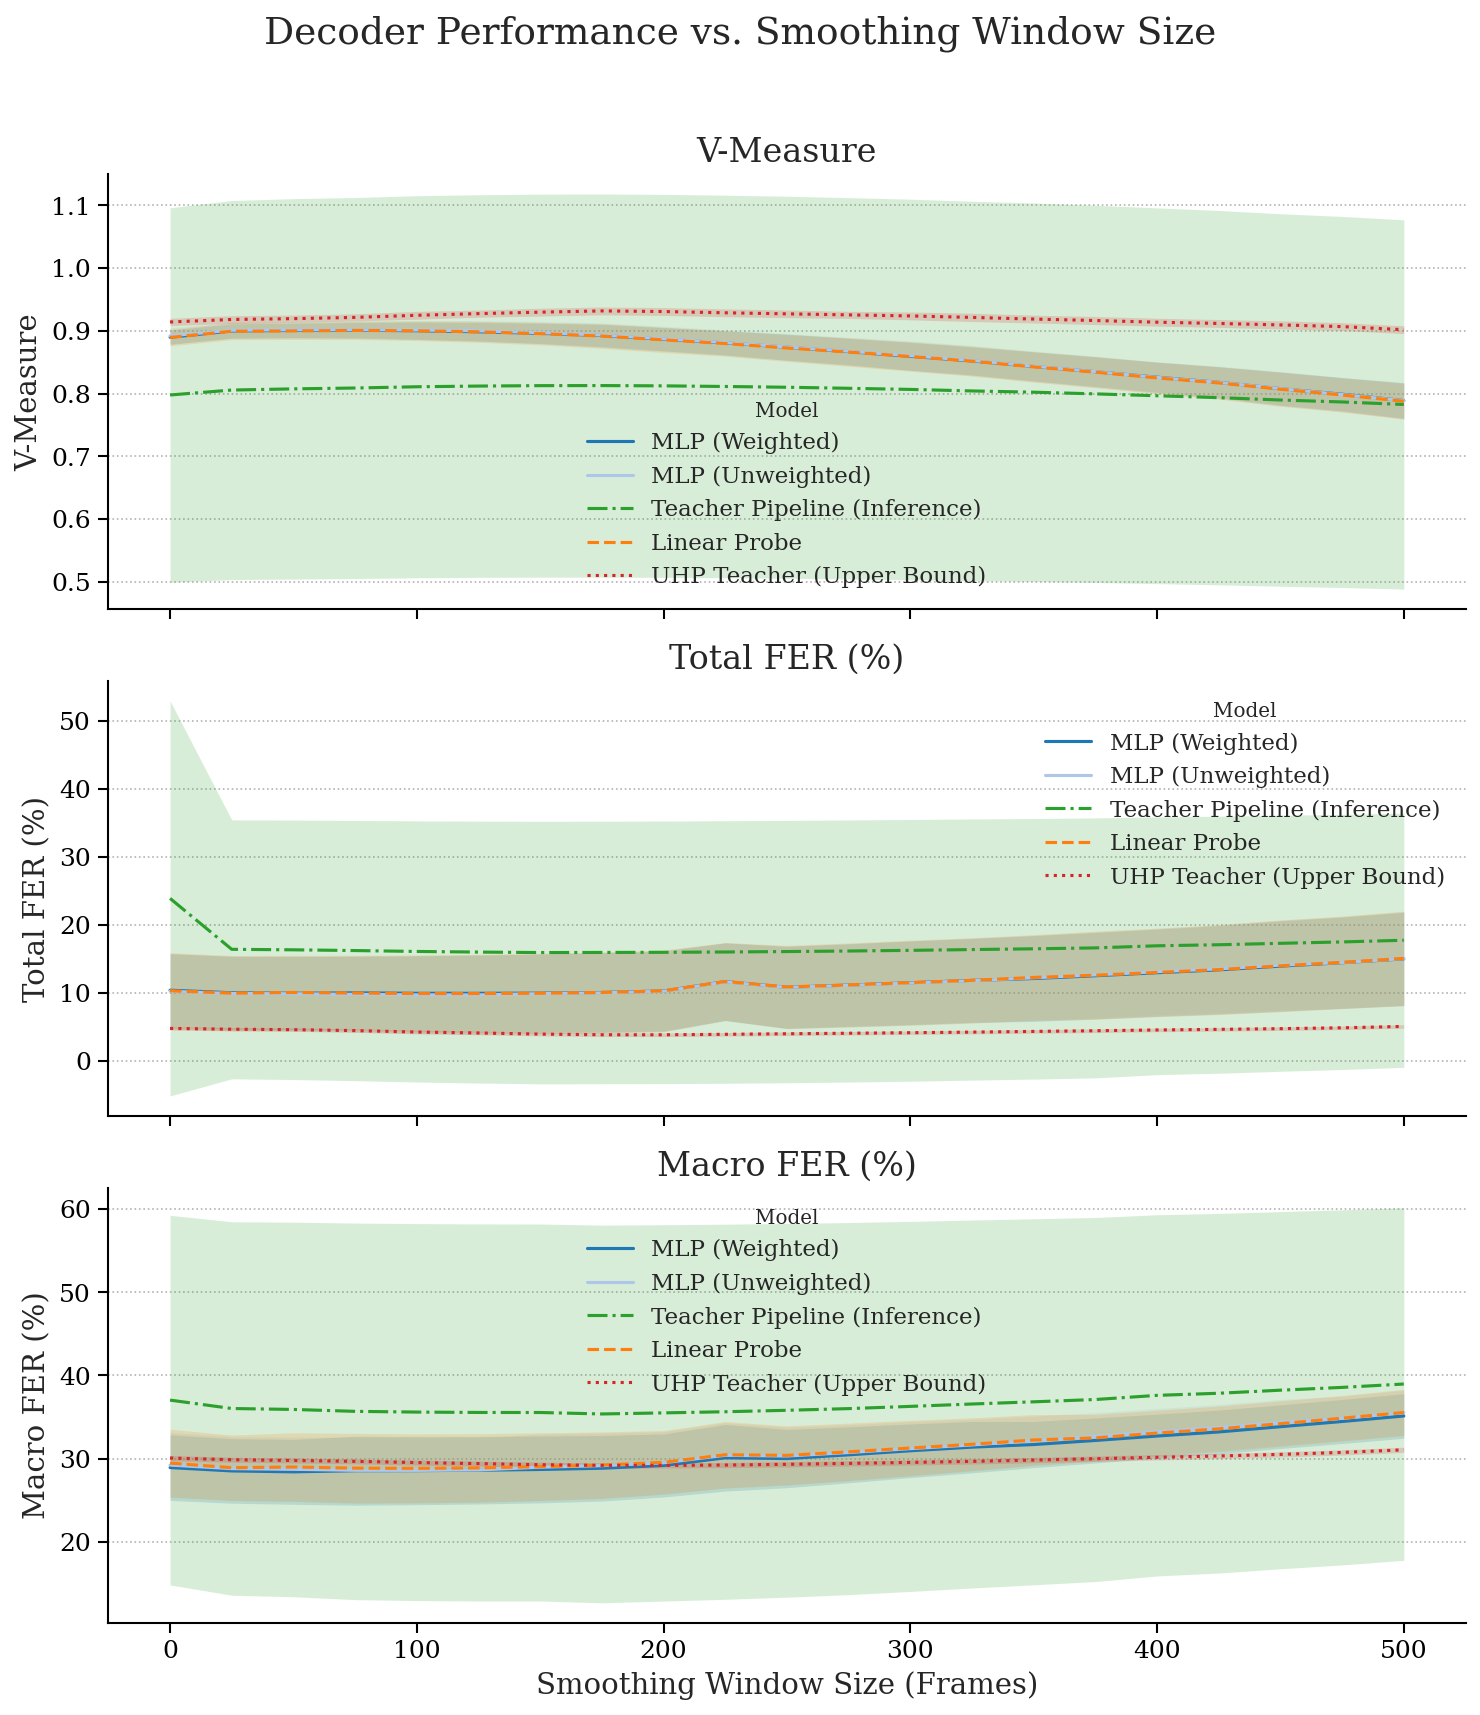


--- Optimal Performance Summary (Mean ± Std. Dev. across folds) ---
                              Optimal Window      V-Measure  Total FER (%)  Macro FER (%)
Model                                                                                    
MLP (Weighted)                           125  0.899 ± 0.015    9.97 ± 5.63   28.60 ± 4.06
MLP (Unweighted)                         125  0.900 ± 0.016    9.74 ± 5.84   28.64 ± 3.87
Linear Probe                             125  0.899 ± 0.017    9.93 ± 5.78   28.88 ± 4.11
Teacher Pipeline (Inference)             150  0.813 ± 0.305  15.96 ± 19.29  35.55 ± 22.68
UHP Teacher (Upper Bound)                200  0.931 ± 0.006    3.88 ± 0.26   29.18 ± 0.31


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pathlib import Path

# --- Style setup to match the 6-panel plot ---
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper")

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'Bitstream Vera Serif'],
    'font.size': 11,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'grid.color': 'grey',
    'grid.linestyle': ':',
    'grid.alpha': 0.5,
    'figure.dpi': 150,
})

# Define a professional color and style palette for the models
palette = {
    "MLP (Weighted)": "#1f77b4",   # Muted Blue
    "MLP (Unweighted)": "#aec7e8", # Light Blue
    "Linear Probe": "#ff7f0e",     # Orange
    "Teacher Pipeline (Inference)": "#2ca02c", # Green
    "UHP Teacher (Upper Bound)": "#d62728",    # Red
}

style_map = {
    "MLP (Weighted)": "-",         # Solid
    "MLP (Unweighted)": "-",       # Solid
    "Linear Probe": "--",          # Dashed
    "Teacher Pipeline (Inference)": "-.",       # Dash-dot
    "UHP Teacher (Upper Bound)": ":",           # Dotted
}


def parse_metrics_file(filepath: Path) -> pd.DataFrame:
    """Parses the structured text file dump of metrics into a pandas DataFrame."""
    if not filepath.exists():
        raise FileNotFoundError(f"The specified metrics file was not found at: {filepath}")

    pattern = re.compile(
        r"File: (.*?),\s+Window: (\d+)\n"
        r"\s+v-measure=([\d.]+),\s+"
        r"total_fer=([\d.]+)%,\s+"
        r"matched_fer=([\d.]+)%,\s+"
        r"macro_fer=([\d.]+)%"
    )

    with open(filepath, 'r') as f:
        content = f.read()

    matches = pattern.findall(content)
    
    data = []
    for match in matches:
        data.append({
            "file": match[0],
            "window": int(match[1]),
            "v_measure": float(match[2]),
            "total_fer": float(match[3]),
            "matched_fer": float(match[4]),
            "macro_fer": float(match[5])
        })
        
    if not data:
        print("Warning: No matches found in the file. Check the file format.")
        return pd.DataFrame()

    return pd.DataFrame(data)

def extract_model_type(filename: str) -> str:
    """Extracts a clean model name from the filename."""
    if "mlp_weighted" in filename: return "MLP (Weighted)"
    if "mlp_unweighted" in filename: return "MLP (Unweighted)"
    if "linear_probe" in filename: return "Linear Probe"
    if "cuml_transform_predict" in filename: return "Teacher Pipeline (Inference)"
    if "upper_limit_decoder" in filename: return "UHP Teacher (Upper Bound)"
    return "Unknown"

# --- Main Execution ---
if __name__ == "__main__":
    filepath = Path("/home/george-vengrovski/Documents/projects/tweety_bert_paper/results/decoder_avg_perf_eval/smoothing_window_metrics_rerun.txt")
    
    # 1. Parse and process the data
    df = parse_metrics_file(filepath)

    if not df.empty:
        df['model_type'] = df['file'].apply(extract_model_type)
        df_cleaned = df[df['model_type'] != 'Unknown']
        df_cleaned['window'] = pd.to_numeric(df_cleaned['window'])

        # Use all model types present in the palette and style_map
        all_models = [m for m in df_cleaned['model_type'].unique() if m in palette]
        df_plot = df_cleaned[df_cleaned['model_type'].isin(all_models)]

        # 2. Plot the results with the new style
        metrics_to_plot = {
            "V-Measure": "v_measure",
            "Total FER (%)": "total_fer",
            "Macro FER (%)": "macro_fer"
        }
        
        fig, axs = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 12), sharex=True)
        fig.suptitle("Decoder Performance vs. Smoothing Window Size", fontsize=18)

        for i, (title, metric) in enumerate(metrics_to_plot.items()):
            for model_type in all_models:
                data_sub = df_plot[df_plot['model_type'] == model_type]
                linestyle = style_map.get(model_type, "-")
                color = palette.get(model_type, "gray")
                grouped = data_sub.groupby("window")[metric].agg(['mean', 'std']).reset_index()
                axs[i].plot(
                    grouped["window"],
                    grouped["mean"],
                    label=model_type,
                    color=color,
                    linestyle=linestyle,
                    linewidth=1.5,
                )
                axs[i].fill_between(
                    grouped["window"],
                    grouped["mean"] - grouped["std"],
                    grouped["mean"] + grouped["std"],
                    color=color,
                    alpha=0.18,
                    linewidth=0
                )
            
            axs[i].set_title(title)
            axs[i].set_ylabel(title)
            axs[i].grid(axis='y', linestyle=':', color='grey', alpha=0.6)
            axs[i].xaxis.grid(False)
            axs[i].tick_params(axis='both', which='both', direction='out')
            axs[i].legend(title="Model")

        axs[-1].set_xlabel("Smoothing Window Size (Frames)")

        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.savefig("decoder_smoothing_performance_styled.png", dpi=300)
        plt.show()

        # --- Replacement for Section 3 ---

        # 3. Generate a fair comparison summary table
        # This finds the optimal smoothing window for each model (based on lowest mean Total FER)
        # and then reports the mean and standard deviation of all metrics at that window.
        print("\n--- Optimal Performance Summary (Mean ± Std. Dev. across folds) ---")

        summary_data = []
        model_order = [m for m in palette if m in df_plot['model_type'].unique()]

        for model_type in model_order:
            model_df = df_plot[df_plot['model_type'] == model_type].copy()
            
            # First, find the optimal window by averaging across folds for each window
            perf_by_window = model_df.groupby('window')['total_fer'].mean()
            optimal_window = perf_by_window.idxmin()
            
            # Now, get all the raw results (across all folds) at that single optimal window
            optimal_perf_df = model_df[model_df['window'] == optimal_window]
            
            # Calculate the mean and std for all metrics across the folds at this window
            mean_metrics = optimal_perf_df.mean(numeric_only=True)
            std_metrics = optimal_perf_df.std(numeric_only=True)
            
            summary_data.append({
                "Model": model_type,
                "Optimal Window": int(optimal_window),
                "V-Measure": f"{mean_metrics['v_measure']:.3f} ± {std_metrics['v_measure']:.3f}",
                "Total FER (%)": f"{mean_metrics['total_fer']:.2f} ± {std_metrics['total_fer']:.2f}",
                "Macro FER (%)": f"{mean_metrics['macro_fer']:.2f} ± {std_metrics['macro_fer']:.2f}"
            })

        summary_df = pd.DataFrame(summary_data).set_index('Model')

        # Print the final, correctly aggregated results
        print(summary_df.to_string())